# New Language Anxiety Code - 5

## Import Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional, Embedding, Dropout, SpatialDropout1D

import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

## Setting Random Seed

In [ ]:
# Set random seed for reproducibility
seed = 2024
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

## Reading The Dataset

In [ ]:
df = pd.read_excel('/content/Merged Anxiety Dataset.xlsx')
df = df[["Post", "LA Class"]]
df.head()

,Post,LA Class
0,"Currently, social networking, especially in th...",Anxiety
1,The innovation of technology has transformed a...,Anxiety
2,Adventure is a window to explore the world and...,Anxiety
3,Lack of sexual education in children in Indone...,No Anxiety
4,Imagine no longer needing to be stuck in traff...,Anxiety


## Encoding The Target Variable

In [ ]:
# Menggunakan mapping manual dengan map
df['la_class'] = df['LA Class'].map({'Anxiety': 1, 'No Anxiety': 0})

# Menampilkan hasil
print("Mapping kelas ke nilai encoded:")
print(df[['LA Class', 'la_class']])

# Menghapus kolom asli
df.drop(columns=['LA Class'], inplace=True)

Mapping kelas ke nilai encoded:
       LA Class  la_class
0       Anxiety         1
1       Anxiety         1
2       Anxiety         1
3    No Anxiety         0
4       Anxiety         1
..          ...       ...
354     Anxiety         1
355     Anxiety         1
356     Anxiety         1
357     Anxiety         1
358     Anxiety         1

[359 rows x 2 columns]


## Text Preprocessing & Cleaning

### Contraction Mapping

In [ ]:
contraction_mapping = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how does",
    "I'd": "I had",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she had",
    "she'd've": "she would have",
    "she'll": "she she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that had",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they had",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
}

def expand_contractions(text, contraction_mapping):
    for contraction, expanded in contraction_mapping.items():
        text = text.replace(contraction, expanded)
    return text

df['Post'] = df['Post'].apply(lambda x: expand_contractions(x, contraction_mapping))

### Cleaning The Text

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in set(all_stopwords)]
    return ' '.join(words)

df['Post'] = df['Post'].apply(preprocess_text)
df['text_length'] = df['Post'].apply(len)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Splitting The Dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['Post'], df['la_class'], test_size=0.2, stratify=df['la_class'], random_state=seed)

## Hyperparameter

In [ ]:
max_len = df['text_length'].max()
vocab_size = 800
embedding_dim = 32
drop_value = 0.6
early_stop = EarlyStopping(monitor='val_loss', patience=10)

## Tokenizing

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, char_level=False, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences, maxlen=max_len, padding='pre', truncating='post')
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_len, padding='pre', truncating='post')

## Getting Class Weights

In [ ]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 1.9657534246575343, 1: 0.6705607476635514}

## LSTM Model Architecture

In [ ]:
# LSTM Model
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model1.add(SpatialDropout1D(drop_value))
model1.add(LSTM(64, return_sequences=False))
model1.add(Dropout(drop_value))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.AdamW(), metrics=['accuracy'])
model1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_12                 │ ?                           │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## GRU Model Architecture

In [ ]:
# GRU Model
model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model2.add(SpatialDropout1D(drop_value))
model2.add(GRU(32, return_sequences=False))
model2.add(Dropout(drop_value))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.AdamW(), metrics=['accuracy'])
model2.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_13                 │ ?                           │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_6 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Bi-LSTM Model Architecture

In [ ]:
# Bi-LSTM Model
model3 = Sequential()
model3.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model3.add(SpatialDropout1D(drop_value))
model3.add(Bidirectional(LSTM(32, return_sequences=False)))
model3.add(Dropout(drop_value))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.AdamW(), metrics=['accuracy'])
model3.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_14                 │ ?                           │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Bi-GRU Model Architecture

In [ ]:
# Bi-GRU Model
model4 = Sequential()
model4.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model4.add(SpatialDropout1D(drop_value))
model4.add(Bidirectional(GRU(32, return_sequences=False)))
model4.add(Dropout(drop_value))
model4.add(Dense(1, activation='sigmoid'))
model4.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.AdamW(), metrics=['accuracy'])
model4.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_15                 │ ?                           │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Model Training

### LSTM

#### Training LSTM

In [ ]:
# Train LSTM
history1 = model1.fit(training_padded, y_train, epochs=20, validation_data=(testing_padded, y_test), class_weight=class_weight_dict, verbose=1, callbacks=[early_stop])

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 247ms/step - accuracy: 0.5693 - loss: 0.6820 - val_accuracy: 0.6528 - val_loss: 0.6912
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.6538 - loss: 0.6797 - val_accuracy: 0.5556 - val_loss: 0.6920
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.5818 - loss: 0.6802 - val_accuracy: 0.5417 - val_loss: 0.6912
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.6901 - loss: 0.6748 - val_accuracy: 0.4028 - val_loss: 0.6960
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.6323 - loss: 0.6691 - val_accuracy: 0.3056 - val_loss: 0.7611
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.5347 - loss: 0.6577 - val_accuracy: 0.5417 - val_loss: 0.6810
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.8480 - loss: 0.6305 - val_accuracy: 0.4583 - val_loss: 0.6917
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.7734 - loss: 0.6038 - val_accuracy: 0.4861 - val_loss:

#### LSTM Model Performances

In [ ]:
# Melakukan prediksi
y_pred_prob = model1.predict(testing_padded)
y_pred_binary = (y_pred_prob > 0.5).astype(int)

# Menampilkan classification report
print(classification_report(y_test, y_pred_binary))

print()

# Menghitung metrik lainnya
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
f1_macro = f1_score(y_test, y_pred_binary, average='macro')
f1_weighted = f1_score(y_test, y_pred_binary, average='weighted')

# Menampilkan metrik secara terpisah
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F1 Score (macro): {f1_macro:.2f}')
print(f'F1 Score (weighted): {f1_weighted:.2f}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
              precision    recall  f1-score   support

           0       0.28      0.44      0.34        18
           1       0.77      0.61      0.68        54

    accuracy                           0.57        72
   macro avg       0.52      0.53      0.51        72
weighted avg       0.64      0.57      0.60        72


Accuracy: 0.57
Precision: 0.77
Recall: 0.61
F1 Score: 0.68
F1 Score (macro): 0.51
F1 Score (weighted): 0.60


#### LSTM Result Visualization

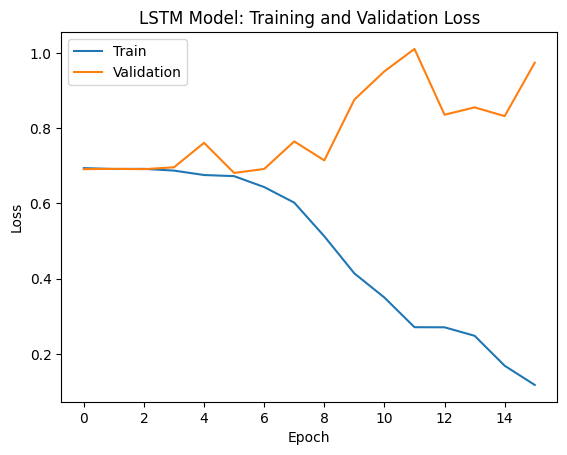

In [ ]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('LSTM Model: Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### GRU

#### Training GRU

In [ ]:
# Train GRU
history2 = model2.fit(training_padded, y_train, epochs=30, validation_data=(testing_padded, y_test), class_weight=class_weight_dict, verbose=1, callbacks=[early_stop])

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - accuracy: 0.6022 - loss: 0.6797 - val_accuracy: 0.4722 - val_loss: 0.6928
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.5638 - loss: 0.6810 - val_accuracy: 0.4167 - val_loss: 0.6949
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - accuracy: 0.6053 - loss: 0.6754 - val_accuracy: 0.3889 - val_loss: 0.6961
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.6100 - loss: 0.6716 - val_accuracy: 0.3750 - val_loss: 0.6980
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.5874 - loss: 0.6673 - val_accuracy: 0.4028 - val_loss: 0.6976
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.6311 - loss: 0.6632 - val_accuracy: 0.4028 - val_loss: 0.6983
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.7274 - loss: 0.6514 - val_accuracy: 0.5139 - val_loss: 0.6942
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.7329 - loss: 0.6333 - val_accuracy: 0.5417 - val_loss:

#### GRU Model Performances

In [ ]:
# Melakukan prediksi
y_pred_prob = model2.predict(testing_padded)
y_pred_binary = (y_pred_prob > 0.5).astype(int)

# Menampilkan classification report
print(classification_report(y_test, y_pred_binary))

print()

# Menghitung metrik lainnya
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
f1_macro = f1_score(y_test, y_pred_binary, average='macro')
f1_weighted = f1_score(y_test, y_pred_binary, average='weighted')

# Menampilkan metrik secara terpisah
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F1 Score (macro): {f1_macro:.2f}')
print(f'F1 Score (weighted): {f1_weighted:.2f}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
              precision    recall  f1-score   support

           0       0.36      0.28      0.31        18
           1       0.78      0.83      0.80        54

    accuracy                           0.69        72
   macro avg       0.57      0.56      0.56        72
weighted avg       0.67      0.69      0.68        72


Accuracy: 0.69
Precision: 0.78
Recall: 0.83
F1 Score: 0.80
F1 Score (macro): 0.56
F1 Score (weighted): 0.68


#### GRU Result Visualization

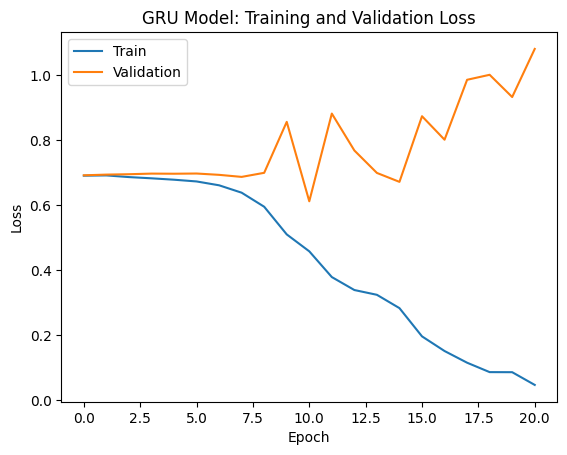

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('GRU Model: Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Bi-LSTM

#### Training Bi-LSTM

In [ ]:
# Train Bi-LSTM
history3 = model3.fit(training_padded, y_train, epochs=30, validation_data=(testing_padded, y_test), class_weight=class_weight_dict, verbose=1, callbacks=[early_stop])

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 364ms/step - accuracy: 0.5390 - loss: 0.6828 - val_accuracy: 0.7500 - val_loss: 0.6896
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 302ms/step - accuracy: 0.6274 - loss: 0.6778 - val_accuracy: 0.7361 - val_loss: 0.6880
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 371ms/step - accuracy: 0.6345 - loss: 0.6793 - val_accuracy: 0.7083 - val_loss: 0.6880
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 467ms/step - accuracy: 0.6163 - loss: 0.6783 - val_accuracy: 0.7222 - val_loss: 0.6866
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step - accuracy: 0.6821 - loss: 0.6751 - val_accuracy: 0.6944 - val_loss: 0.6886
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 302ms/step - accuracy: 0.6647 - loss: 0.6705 - val_accuracy: 0.3611 - val_loss: 0.7001
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 261ms/step - accuracy: 0.5900 - loss: 0.6590 - val_accuracy: 0.5556 - val_loss: 0.6654
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 300ms/step - accuracy: 0.7464 - loss: 0.6361 - val_accuracy: 0.4444 - val_loss:

#### Bi-LSTM Model Performances

In [ ]:
# Melakukan prediksi
y_pred_prob = model3.predict(testing_padded)
y_pred_binary = (y_pred_prob > 0.5).astype(int)

# Menampilkan classification report
print(classification_report(y_test, y_pred_binary))

print()

# Menghitung metrik lainnya
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
f1_macro = f1_score(y_test, y_pred_binary, average='macro')
f1_weighted = f1_score(y_test, y_pred_binary, average='weighted')

# Menampilkan metrik secara terpisah
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F1 Score (macro): {f1_macro:.2f}')
print(f'F1 Score (weighted): {f1_weighted:.2f}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step
              precision    recall  f1-score   support

           0       0.35      0.50      0.41        18
           1       0.80      0.69      0.74        54

    accuracy                           0.64        72
   macro avg       0.58      0.59      0.57        72
weighted avg       0.69      0.64      0.66        72


Accuracy: 0.64
Precision: 0.80
Recall: 0.69
F1 Score: 0.74
F1 Score (macro): 0.57
F1 Score (weighted): 0.66


#### Bi-LSTM Result Visualization

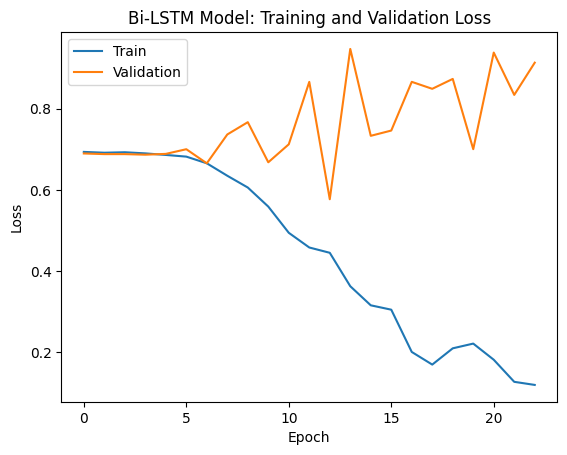

In [ ]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Bi-LSTM Model: Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Bi-GRU

#### Training Bi-GRU

In [ ]:
# Train Bi-GRU
history4 = model4.fit(training_padded, y_train, epochs=30, validation_data=(testing_padded, y_test), class_weight=class_weight_dict, verbose=1, callbacks=[early_stop])

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 341ms/step - accuracy: 0.5568 - loss: 0.6837 - val_accuracy: 0.7500 - val_loss: 0.6869
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 299ms/step - accuracy: 0.6023 - loss: 0.6807 - val_accuracy: 0.7778 - val_loss: 0.6901
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 267ms/step - accuracy: 0.5601 - loss: 0.6795 - val_accuracy: 0.3889 - val_loss: 0.6943
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step - accuracy: 0.5195 - loss: 0.6797 - val_accuracy: 0.2500 - val_loss: 0.6980
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step - accuracy: 0.4933 - loss: 0.6765 - val_accuracy: 0.2639 - val_loss: 0.7007
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 357ms/step - accuracy: 0.4504 - loss: 0.6774 - val_accuracy: 0.2500 - val_loss: 0.7017
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 263ms/step - accuracy: 0.4822 - loss: 0.6723 - val_accuracy: 0.2917 - val_loss: 0.7024
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step - accuracy: 0.5094 - loss: 0.6734 - val_accuracy: 0.3750 - val_loss:

#### Bi-GRU Model Performances

In [ ]:
# Melakukan prediksi
y_pred_prob = model4.predict(testing_padded)
y_pred_binary = (y_pred_prob > 0.5).astype(int)

# Menampilkan classification report
print(classification_report(y_test, y_pred_binary))

print()

# Menghitung metrik lainnya
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
f1_macro = f1_score(y_test, y_pred_binary, average='macro')
f1_weighted = f1_score(y_test, y_pred_binary, average='weighted')

# Menampilkan metrik secara terpisah
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F1 Score (macro): {f1_macro:.2f}')
print(f'F1 Score (weighted): {f1_weighted:.2f}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step
              precision    recall  f1-score   support

           0       0.20      0.11      0.14        18
           1       0.74      0.85      0.79        54

    accuracy                           0.67        72
   macro avg       0.47      0.48      0.47        72
weighted avg       0.61      0.67      0.63        72


Accuracy: 0.67
Precision: 0.74
Recall: 0.85
F1 Score: 0.79
F1 Score (macro): 0.47
F1 Score (weighted): 0.63


#### Bi-GRU Result Visualization

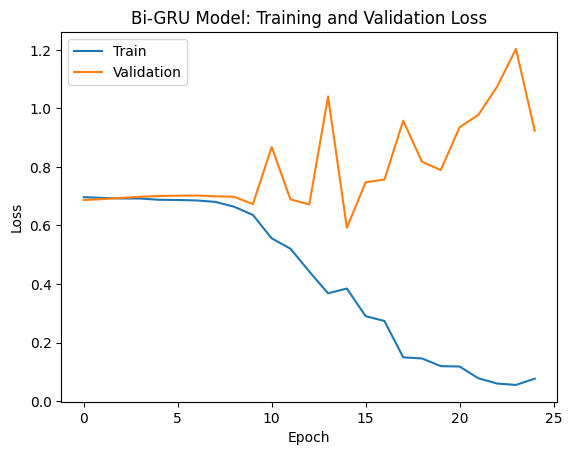

In [ ]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Bi-GRU Model: Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Soft Voting

In [ ]:
# Soft Voting
y_pred_prob_lstm = model1.predict(testing_padded)
y_pred_prob_gru = model2.predict(testing_padded)
y_pred_prob_bilstm = model3.predict(testing_padded)
y_pred_prob_bigru = model4.predict(testing_padded)

y_pred_prob = (y_pred_prob_lstm + y_pred_prob_gru + y_pred_prob_bilstm + y_pred_prob_bigru) / 4
y_pred_binary = (y_pred_prob > 0.5).astype(int)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


## Model Performances Report

In [ ]:
print(classification_report(y_test, y_pred_binary))

print()

# Menghitung metrik lainnya
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
f1_macro = f1_score(y_test, y_pred_binary, average='macro')
f1_weighted = f1_score(y_test, y_pred_binary, average='weighted')

# Menampilkan metrik secara terpisah
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'F1 Score (macro): {f1_macro:.2f}')
print(f'F1 Score (weighted): {f1_weighted:.2f}')

              precision    recall  f1-score   support

           0       0.37      0.39      0.38        18
           1       0.79      0.78      0.79        54

    accuracy                           0.68        72
   macro avg       0.58      0.58      0.58        72
weighted avg       0.69      0.68      0.68        72


Accuracy: 0.68
Precision: 0.79
Recall: 0.78
F1 Score: 0.79
F1 Score (macro): 0.58
F1 Score (weighted): 0.68
